In [1]:
import pandas as pd
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv("email_data.csv")

In [3]:
df.head(3)

,Unnamed: 0,user,folder,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,body
0,14,allen-p,_sent_mail,"Thu, 5 Oct 2000 06:26:00 -0700 (PDT)",phillip.allen@enron.com,david.delainey@enron.com,NaN,Phillip K Allen,David W Delainey,NaN,NaN,"Dave, \n\n Here are the names of the west desk..."
1,15,allen-p,_sent_mail,"Thu, 5 Oct 2000 05:55:00 -0700 (PDT)",phillip.allen@enron.com,paula.harris@enron.com,Re: 2001 Margin Plan,Phillip K Allen,Paula Harris,NaN,NaN,"Paula,\n\n 35 million is fine\n\nPhillip"
2,16,allen-p,_sent_mail,"Wed, 4 Oct 2000 09:23:00 -0700 (PDT)",phillip.allen@enron.com,ina.rangel@enron.com,"Var, Reporting and Resources Meeting",Phillip K Allen,Ina Rangel,NaN,NaN,---------------------- Forwarded by Phillip K ...


In [4]:
df.shape

(55958, 12)

In [5]:
df.isna().sum()

Unnamed: 0        0
user              0
folder            0
Date              0
From              0
To             2821
Subject        1842
X-From            1
X-To           1053
X-cc          42447
X-bcc         55921
body              0
dtype: int64

Subject column has some NA values, hence using body feature

In [6]:
#stopword removal and lemmatization
stopwords = nltk.corpus.stopwords.words('english')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/akshay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)
    text = re.sub("\n", " ", text)
    
    return text

In [8]:
def lemmatize_text(text):
    text = [lemmatizer.lemmatize(w) for w in text.split()]
    text = " ".join(text)
    return text

In [9]:
df['body_clean'] = df['body'].apply(lambda x: clean_text(x))

In [10]:
df['body_clean'] = df.body_clean.apply(lemmatize_text)

In [11]:
df[["body", "body_clean"]].head(2)

,body,body_clean
0,"Dave, \n\n Here are the names of the west desk...",dave here are the name of the west desk member...
1,"Paula,\n\n 35 million is fine\n\nPhillip",paula 35 million is fine phillip


In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(df.body_clean)

In [13]:
tfidf_matrix.shape

(55958, 100)

In [15]:
test_string = ["miss document"]
test_vec = tfidf_vectorizer.transform(test_string)

In [78]:
from sklearn.metrics.pairwise import linear_kernel

# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix[:1000, :], test_vec)

In [80]:
import numpy as np
interest_idx = list(np.where(cosine_sim > 0.1)[0])
# interest_idx

In [81]:
interest_text = df.body_clean.iloc[interest_idx]

In [82]:
from collections import Counter
from nltk.corpus import stopwords

In [83]:
def get_most_common_words(df):
    stop = set(stopwords.words("english"))
    corpus = [word for i in df.str.split().values.tolist() for word in i if (word not in stop)]
    most_common = Counter(corpus).most_common(10)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)
        
    return words, frequency

In [84]:
words, freq = get_most_common_words(interest_text)

<AxesSubplot:>

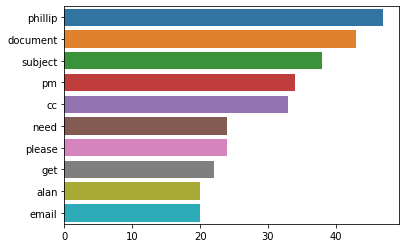

In [85]:
import seaborn as sns
sns.barplot(x = freq, y = words)

In [89]:
def get_ngram_freq(n, df):
    stop = set(stopwords.words("english"))
    vectorizer = CountVectorizer(stop_words = stop, 
                          ngram_range = (n, n))

    # Matrix of ngrams
    bag_words = vectorizer.fit_transform(df)

    # Count frequency of ngrams
    count_values = bag_words.toarray().sum(axis=0)

    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame([(count_values[i], k) for k, i in vec.vocabulary_.items()])
    ngram_freq.columns = ["frequency", "ngram"]
    ngram_freq.sort_values(by = "frequency",  ascending = False, inplace = True)

    return ngram_freq

In [90]:
freq_2 = get_ngram_freq(2, interest_text)

In [91]:
freq_2

,frequency,ngram
1557,14,theoretical pl
555,13,original message
1556,12,greek theoretical
1628,11,cc subject
1266,9,would like
...,...,...
1141,1,distinction utility
1140,1,make distinction
1139,1,also make
1138,1,line also


<AxesSubplot:xlabel='frequency', ylabel='ngram'>

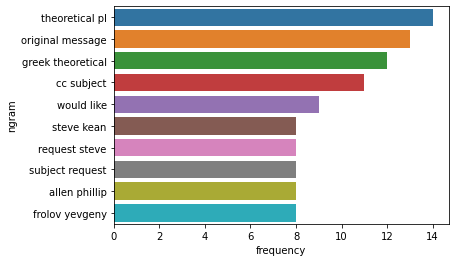

In [94]:
sns.barplot(freq_2.head(10), x = "frequency", y = "ngram")